# __Réseau de neurones convolutif (CNN)__
---

## __Préparations__

### *Importations*

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# from keras.application.vgg16 import vgg16
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten
from keras.models import Model

import tensorflow as tf
import datetime
import cv2
import shutil
from tensorflow import keras

from re import X
from csv import DictWriter
import csv

import datetime

import sklearn
import sklearn.metrics
import itertools
import io
from keras.utils.vis_utils import plot_model

%load_ext tensorboard

### *TensorBoard*

In [2]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir = "LogsBoard",
    histogram_freq = 1
)

In [3]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = f"logs/weight/{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}",
    monitor = "val_loss",
    save_weights_only = True,
    save_best_only = True,
    verbose = 1
)

In [4]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss",
    min_delta = 0,
    patience = 3,
    verbose = 1,
    mode = "auto",
    baseline = None,
    restore_best_weights = False
)

In [5]:
#fonction utiles
def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    return image


def plot_confusion_matrix(cm_main, class_names, figsize=(5, 5), accuracy_score=None):
    #Crée un matplotlib plot à partir d'une matrice de confusion numérique et des labels associée
    figure = plt.figure(figsize=figsize)
    ax = plt.imshow(cm_main, interpolation='nearest', cmap=plt.cm.Blues)
    str_title = "Confusion matrix"
    if accuracy_score is not None:
        str_title = str_title + f" acc:{np.round(accuracy_score*100, decimals=3)}%"
    plt.title(str_title)
    
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)



    threshold = 0.5
    # write labels
    for i, j in itertools.product(range(cm_main.shape[0]), range(cm_main.shape[1])):
        val = cm_main[i, j]
        if val >= 0:
            color = "white" if cm_main[i, j] > threshold else "black"
            plt.text(j, i, cm_main[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def model_to_confusion_matrix(model, x_test, y_test, class_names, plotIt = True):

    y_pred_onehot = model.predict(x_test)
    y_pred = np.argmax(y_pred_onehot, axis=1)
    # Calculate the confusion matrix.
    cm_norm = None
    figure = None
    if y_test.ndim > 1:
        y_test = y_test.squeeze()

    if y_pred.ndim > 1:
        y_pred = y_pred.squeeze()

    idx = np.unique(np.concatenate((y_test, y_pred)))

    cm = sklearn.metrics.confusion_matrix(y_test, y_pred)

    acc = sklearn.metrics.accuracy_score(y_test, y_pred)
    # compute normalzed confusion matrix
    cm_norm = sklearn.metrics.confusion_matrix(y_test, y_pred, normalize="true")
    cm_norm = np.round(cm_norm, decimals=2)
    # print("cm_norm", cm_norm)
    if plotIt:
        cm_main= cm_norm
        # Log the confusion matrix as an image summary.
        n=len(class_names)
        figure = plot_confusion_matrix(cm_main, class_names, figsize=(n,n), accuracy_score=acc)
    # cm, y_pred, y_pred_onehot, (optional: cm_norm, figure)
    return cm, y_pred, y_pred_onehot, cm_norm, figure

In [6]:
#définition du callback perso
class ConfusionMatrixCallback(keras.callbacks.Callback):
    def __init__(self, x_test, y_test, class_names=None, file_writer_cm = tf.summary.create_file_writer('logs/cm')):
        
        self.x_test = x_test
        self.y_test = y_test
        self.class_names = class_names if class_names is not None else np.unique(y_test)
        self.file_writer_cm = file_writer_cm
        
    
    def on_epoch_end(self, epoch, logs=None):

        _, _, _, _, figure = model_to_confusion_matrix(self.model, self.x_test,self.y_test,self.class_names)
        # Log the confusion matrix as an image summary.
        cm_image = plot_to_image(figure)

        # Log the confusion matrix as an image summary.
        with self.file_writer_cm.as_default():
            
            tf.summary.image("Confusion Matrix", cm_image, step=epoch)
            self.file_writer_cm.flush()
            print(self.file_writer_cm)



2022-10-19 20:53:34.659679: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-19 20:53:34.709831: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-19 20:53:34.709997: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-19 20:53:34.710579: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## __Modèle du CNN__

Les couches de convolutions vont nous permettent d'extraire divers caractéristiques dans l'image (un coin, un contour etc...). Ainsi, nous pouvons déterminer la présence de certaines formes, de motifs ou encore bien d'autre.
<br /><br />

Un bloc convolutif est constitué de deux couches spécifiques

- La couche convolutive, comme expliqué rapidement au-dessus, elle permet d'identifier et d'extraire des caractéristiques.
- La couche de pooling permet de compresser la sortie de la couche convolutive. Pour ce faire, elle récupère l'information, souvent la plus élevée ([max pooling](https://fr.wikipedia.org/wiki/Max_pooling)).

Nous souhaitons garder quelques informations sur un csv. Afin de pouvoir également faire des graphiques sans utiliser tensorflow.

In [7]:
from re import X
from csv import DictWriter
import csv
import matplotlib.pyplot as plt


def AccuracySave(n_dropout, nb_epoch, min_delta, patience, accuracy ):
  # Import DictWriter class from CSV module
  
  # list of column names 
  field_names = ['N_Dropout','Nb_Epoch', 'Min_Delta', 'Patience', 'Accuracy']
    
  # Dictionary
  dict={'N_Dropout':n_dropout,'Nb_Epoch': nb_epoch,'Min_Delta':min_delta,        #A mettre les bonnes caractéristiques
        'Patience':patience, 'Accuracy': accuracy}
    
  with open('Graphe.csv', 'a') as f_object:
        
      dictwriter_object = DictWriter(f_object, fieldnames=field_names)
    
      dictwriter_object.writerow(dict)
    
      f_object.close()

def ShowGraphe(xi, yi):
  x = []
  y = []
  with open('Graphe (5).csv', mode="r") as csv_file:
      reader = csv.reader(csv_file) 

      for item in reader:
          x.append(float(item[xi]))
          y.append(float(item[yi]))

  plt.plot(x, y)
      
  plt.xlabel('x - axis')
  plt.ylabel('y - axis')

  plt.title('Graph title')
  
  plt.show()

def ShowGraphe2(xi, yi):
  x = [1,5,2,3]
  y = [1,15,13,10]

  x = [1,2,3,5]
  y = ['0.85','0.88','0.868','0.863']

  plt.plot(x, y)
      
  plt.xlabel('x - axis')
  plt.ylabel('y - axis')

  plt.title('Graph title')
  
  plt.show()


In [8]:
path_datasets = "../Datasets/TouNum/dataset/multi-class"
destination_dataset = "./content/ProjetDestination"
size= (128, 128)


def loadDataSet(path_datasets, size):
    return (
        tf.keras.preprocessing.image_dataset_from_directory(
          f"{path_datasets}/train/",
          validation_split=0.2,
          subset="training",
          seed=42,
          labels="inferred",
          image_size=size
        ),
        tf.keras.preprocessing.image_dataset_from_directory(
          f"{path_datasets}/train/",
          validation_split=0.2,
          subset="validation",
          seed=42,
          labels="inferred",
          image_size=size
        ),
        tf.keras.preprocessing.image_dataset_from_directory(
          f"{path_datasets}/test/",
          validation_split=0.99,
          subset="validation",
          seed=42,
          labels="inferred",
          image_size=size
        )
    )

In [9]:
train, validate, test = loadDataSet("../Datasets/TouNum/dataset/multi-class", (128, 128))

Found 32798 files belonging to 5 classes.
Using 26239 files for training.
Found 32798 files belonging to 5 classes.
Using 6559 files for validation.
Found 8199 files belonging to 5 classes.
Using 8117 files for validation.


Voici les différents labels que nous retrouvons dans notre data-set.

In [10]:
class_names =  train.class_names
print(class_names)

['Painting', 'Photo', 'Schematics', 'Sketch', 'Text']


In [11]:
#Récupération des labels et des images de test 
# take(-1) take all batches
for images, labels in validate.take(-1):
    x_test = images.numpy()
    y_test = labels.numpy()

confusionMatrix_callback = ConfusionMatrixCallback(x_test, y_test, class_names)

La fonction ci-dessous nous permet de créer notre modèle et d'effectuer toutes les autres actions liées à cette création. Comme la création des logs, l'activation de notre fonction de sauvegarde de données dans un csv, etc...
<br /><br />
Afin d'éviter le sur-apprentissage, nous avons opté pour du dropout ou de l'early stopping. Le dropout lors de l'apprentissage va désactiver les neurones en mettant 0 à la sortie de certains neurones de manière aléatoire, l'intérêt est donc de répartir l'apprentissage sur l'ensemble des neurones.
<br /><br />
Au contraire, pour empêcher le sous-apprentissage, il faut un dataset assez grand. Dans le cas ou le dataset ne suffit pas, la data-augmentation peut-être envisagée. Cette technique consiste à prendre une image pour en créer plusieurs, en effectuant des rotations ou encore des zooms sur cette dernière.

Pour rappel, une fonction de cout ou de perte est défini par la [CNIL](https://www.cnil.fr/) comme [" la quantification de l'écart entre les prévisions du modèle et les observations réelles du jeu de donnée utilisé pendant l'entrainement "](https://elections.cnil.fr/fr/definition/fonction-de-perte-ou-de-cout-loss-function). Dans nos modèles, nous utilisons la sparse categorical corssentropy. Il s'agit de calculer la perte d'entropie croisée entre les étiquettes et les prédictions en fournissant des étiquettes sous formes d'entiers.

Epoch 1/5


2022-10-19 20:56:38.307263: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8500
2022-10-19 20:56:39.093654: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


820/820 [==============================] - ETA: 0s - loss: 0.5812 - accuracy: 0.7475
Epoch 1: val_loss improved from inf to 0.41494, saving model to logs/weight/20221019-205327
820/820 [==============================] - 13s 12ms/step - loss: 0.5812 - accuracy: 0.7475 - val_loss: 0.4149 - val_accuracy: 0.8276
Epoch 2/5
816/820 [============================>.] - ETA: 0s - loss: 0.3706 - accuracy: 0.8505
Epoch 2: val_loss improved from 0.41494 to 0.34027, saving model to logs/weight/20221019-205327
820/820 [==============================] - 10s 12ms/step - loss: 0.3702 - accuracy: 0.8506 - val_loss: 0.3403 - val_accuracy: 0.8600
Epoch 3/5
820/820 [==============================] - ETA: 0s - loss: 0.2985 - accuracy: 0.8800
Epoch 3: val_loss improved from 0.34027 to 0.32040, saving model to logs/weight/20221019-205327
820/820 [==============================] - 12s 14ms/step - loss: 0.2985 - accuracy: 0.8800 - val_loss: 0.3204 - val_accuracy: 0.8771
Epoch 4/5
815/820 [=======================

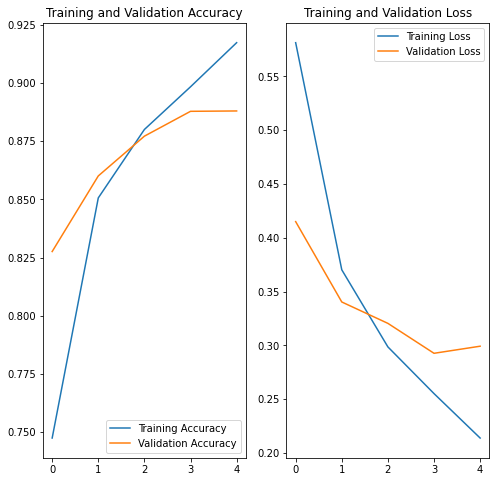

Récupération des données du modèle...


2022-10-19 20:57:32.593508: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./content/racine/test_modele/assets
Récupération terminée !
254/254 - 2s - loss: 0.2967 - accuracy: 0.8897 - 2s/epoch - 7ms/step

Test accuracy: 0.889737606048584


In [18]:
# Mon model
# data_tr, data_val, data_test, n_dropout, nb_epoch, min_delta, patience, tensorboard_logs_dir, racine_dir, modele_name):

ts_logs_dir = './content/LogsBoard'
os.mkdir('./content/racine')
racine = './content/racine'
modele_name = 'test_modele'
output=0

data_tr= train
data_val= validate
data_test= test
n_dropout= 0.3
nb_epoch= 5
min_delta= 0
patience= 5
tensorboard_logs_dir= ts_logs_dir
racine_dir= racine
model_name= modele_name

# Création du modèle
model =tf.keras.models.Sequential([tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(n_dropout),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(5)])

# Compilation du modèle
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])


# Création des logs Tensorboard
logdir = tensorboard_logs_dir
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
# Création de l'early stoping
early_stopping_callback = tf.keras.callbacks.EarlyStopping("val_loss", min_delta=min_delta, patience=patience)

# Enrainement du modèle
history = model.fit(data_tr, validation_data=data_val, callbacks=[tensorboard_callback,cp_callback,confusionMatrix_callback, early_stopping_callback], epochs=nb_epoch)
# Récupération des valeurs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


epochs_range = range(nb_epoch)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


# Récupération des poids et de la structure du modèle
print('Récupération des données du modèle...')
poids = model.get_weights()
path = racine_dir + "/" + modele_name
if os.path.exists(f"{path}") == False:
  os.mkdir(path)
  model.save(path)
  print('Récupération terminée !')

# Test du modèle
test_loss, test_acc = model.evaluate(data_test, verbose=2)
print('\nTest accuracy:', test_acc)

# Récupération dans le csv
AccuracySave(n_dropout,nb_epoch,  min_delta,  patience, test_acc )


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        1

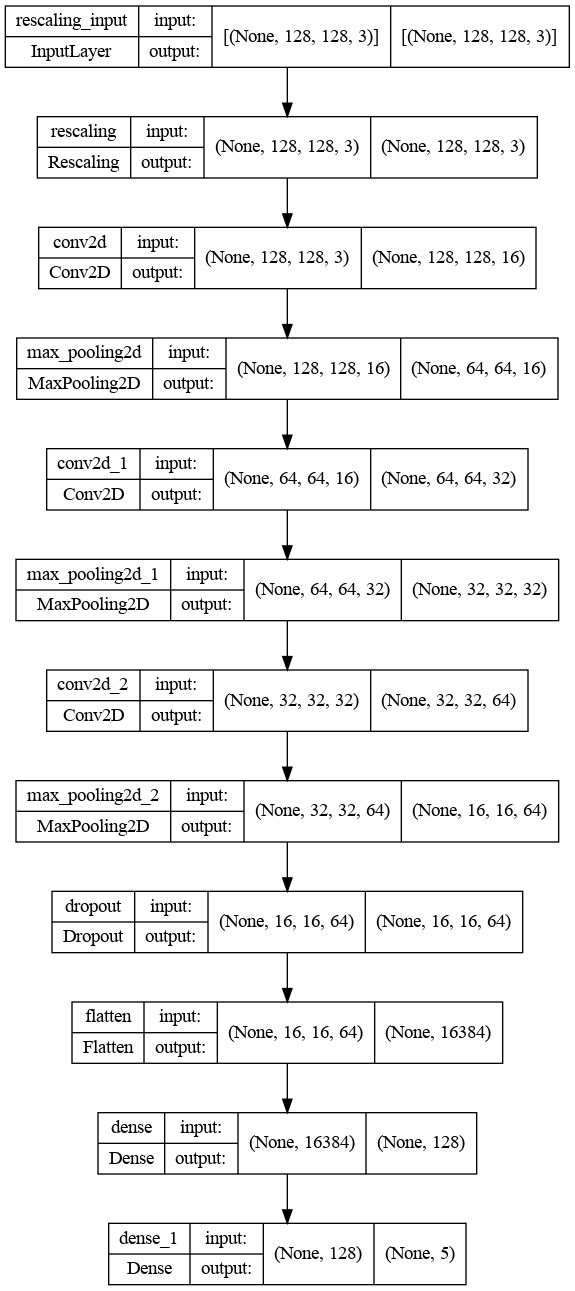

In [19]:
model.summary()
plot_model(
    model,
    to_file = "model_plot.png",
    show_shapes = True,
    show_layer_names = True
)

Affichage de la matrice de confusion.

In [20]:

y_pred=[]
y_real=[]
from tensorflow.keras.preprocessing import image

directory = os.fsencode("../Datasets/TouNum/dataset/multi-class/test/Painting")
counterBonneRep = 0
counterFile = 0
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".jpg") or filename.endswith(".png"): 
        counterFile=counterFile+1
        img = image.load_img(f"../Datasets/TouNum/dataset/multi-class/test/Painting/{filename}", target_size = (128,128))   #meme taille avec laquelle on a entrainée le modèle
        x = image.img_to_array(img)
        x = x[np.newaxis]
        predictions = model.predict(x)
        score = tf.nn.softmax(predictions[0])
        y_pred.append(np.argmax(score))
        if (filename.__contains__("painting")):
            y_real.append(0)

directory = os.fsencode("../Datasets/TouNum/dataset/multi-class/test/Photo")
counterBonneRep = 0
counterFile = 0
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".jpg") or filename.endswith(".png"): 
        counterFile=counterFile+1
        img = image.load_img(f"../Datasets/TouNum/dataset/multi-class/test/Photo/{filename}", target_size = (128,128))   #meme taille avec laquelle on a entrainée le modèle
        x = image.img_to_array(img)
        x = x[np.newaxis]
        predictions=model.predict(x)
        score = tf.nn.softmax(predictions[0])
        y_pred.append(np.argmax(score))
        if (filename.__contains__("photo")):
            y_real.append(1)

directory = os.fsencode("../Datasets/TouNum/dataset/multi-class/test/Schematics")
counterBonneRep = 0
counterFile = 0
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".jpg") or filename.endswith(".png"): 
        counterFile=counterFile+1
        img = image.load_img(f"../Datasets/TouNum/dataset/multi-class/test/Schematics/{filename}", target_size = (128,128))   #meme taille avec laquelle on a entrainée le modèle
        x = image.img_to_array(img)
        x = x[np.newaxis]
        predictions = model.predict(x)
        score = tf.nn.softmax(predictions[0])
        y_pred.append(np.argmax(score))
        if (filename.__contains__("schematics")):
            y_real.append(2)

directory = os.fsencode("../Datasets/TouNum/dataset/multi-class/test/Sketch")
counterBonneRep=0
counterFile=0
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".jpg") or filename.endswith(".png"): 
        counterFile=counterFile+1
        img = image.load_img(f"../Datasets/TouNum/dataset/multi-class/test/Sketch/{filename}", target_size = (128,128))   #meme taille avec laquelle on a entrainée le modèle
        x = image.img_to_array(img)
        x = x[np.newaxis]
        predictions = model.predict(x)
        score = tf.nn.softmax(predictions[0])
        y_pred.append(np.argmax(score))
        if (filename.__contains__("sketch")):
            y_real.append(3)

directory = os.fsencode("../Datasets/TouNum/dataset/multi-class/test/Text")
counterBonneRep = 0
counterFile = 0
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".jpg") or filename.endswith(".png"): 
        counterFile = counterFile + 1
        img = image.load_img(f"../Datasets/TouNum/dataset/multi-class/test/Text/{filename}", target_size = (128,128))   #meme taille avec laquelle on a entrainée le modèle
        x = image.img_to_array(img)
        x = x[np.newaxis]
        predictions = model.predict(x)
        score = tf.nn.softmax(predictions[0])
        y_pred.append(np.argmax(score))
        if (filename.__contains__("text")):
            y_real.append(4)

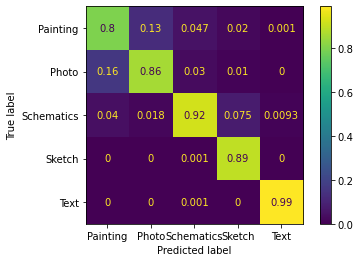

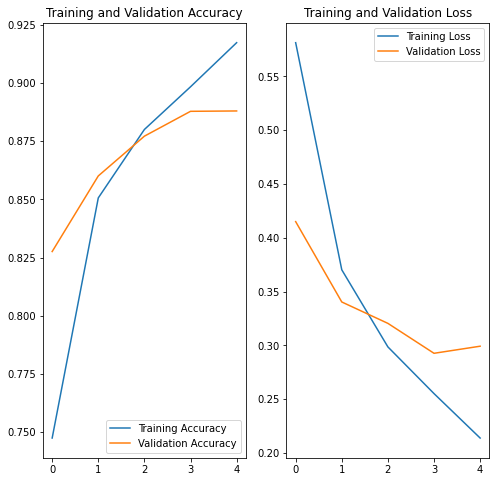


Test accuracy: 0.889737606048584


In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm=confusion_matrix(y_real, y_pred, normalize = "pred")

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = class_names)

disp.plot()
plt.show()

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

print('\nTest accuracy:', test_acc)

## __Transfert learning multi-class__

L'entrainement d'architecture peut être une étape très longue et très fastidieuse. Pourquoi ne pas réutiliser un morceau de réseau de neurones conséquent déjà entrainé. C'est le principe de transfert learning.

Pour illustrer nos propos et continuer notre comparaison, nous avons décidé d'utiliser le modèle VGG-16.

Ce dernier a été conçu par K.Simonyan et A.Zisserman. Il a atteint une précision de test de 92,7% dans ImageNet. ImageNet est un dataset regroupant 14 millions d'images labellisées appartenant à 1000 classes.

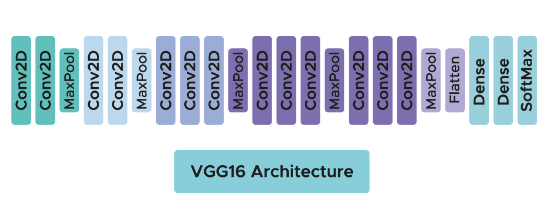

In [24]:
from glob import glob

from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten
from keras.models import Model

In [44]:
data_path = "../Datasets/TouNum/dataset/multi-class"

train_dir = os.path.join(data_path, "train")
test_dir = os.path.join(data_path, "test")

L'entrée de la première couche est une image RGB de taille 128x128. Nous gardons la taille du noyau de convolution de taille 3x3. C'est en effet l'une des spécificités de ce modèle. Le noyau de convolution est relativement de petite taille. Avant la VGG16, les tailles plus grandes étaient privilégiées.

In [29]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

58900480/58889256 [==============================] - 13s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                             

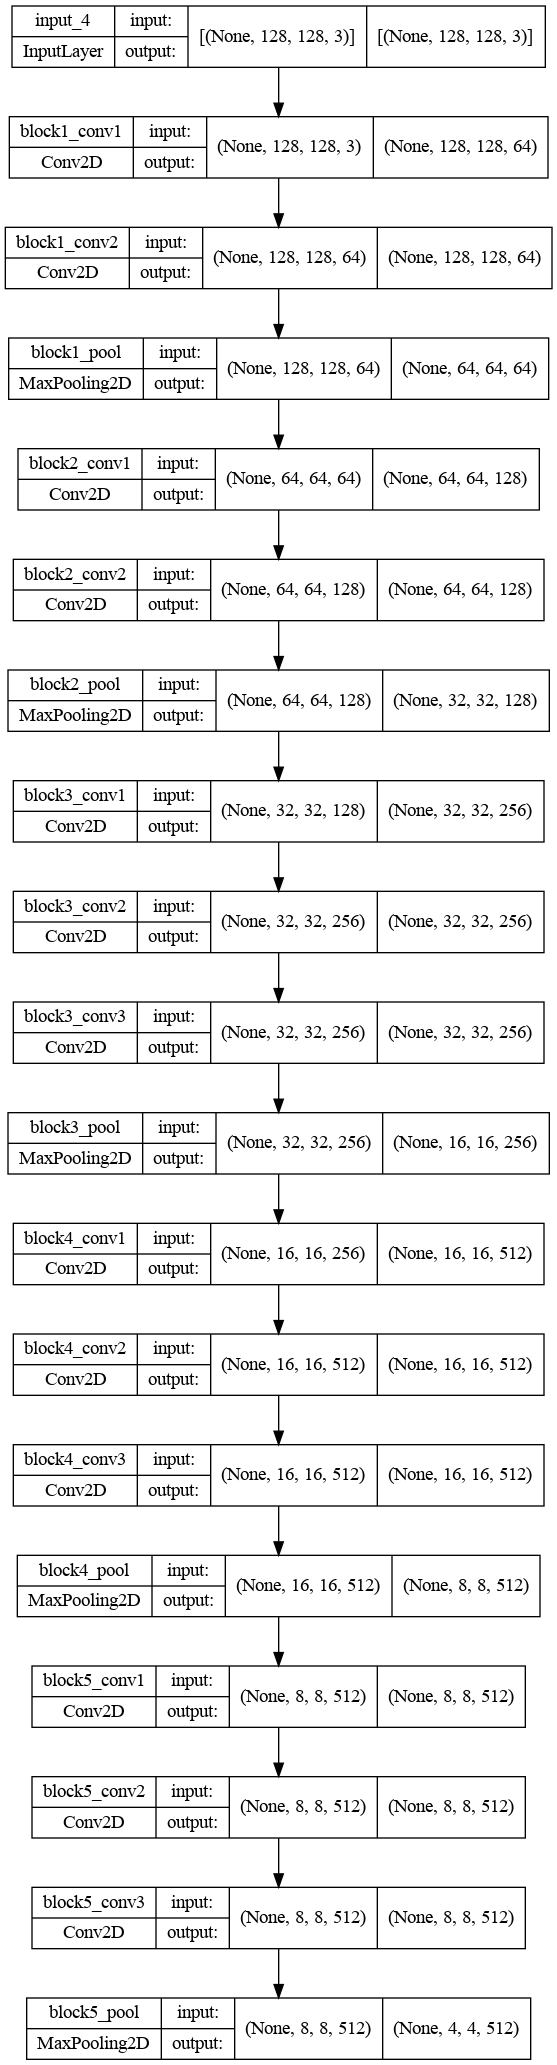

In [30]:
IMG_SHAPE = (128,128,3)

base_model = VGG16(input_shape = IMG_SHAPE, include_top = False, weights = "imagenet")
base_model.summary()
plot_model(base_model, to_file = "base_model_plot.png", show_shapes = True, show_layer_names = True)

In [31]:
# On bloque l'apprentissage du modèle
base_model.trainable = False

In [32]:
base_model.output

<KerasTensor: shape=(None, 4, 4, 512) dtype=float32 (created by layer 'block5_pool')>

On remarque que notre output ne correspond pas à celui que l'on souhaite.

In [33]:
# On définit nos couches de sorties
x = Flatten()(base_model.output)
prediction = Dense(5, activation = "softmax")(x)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

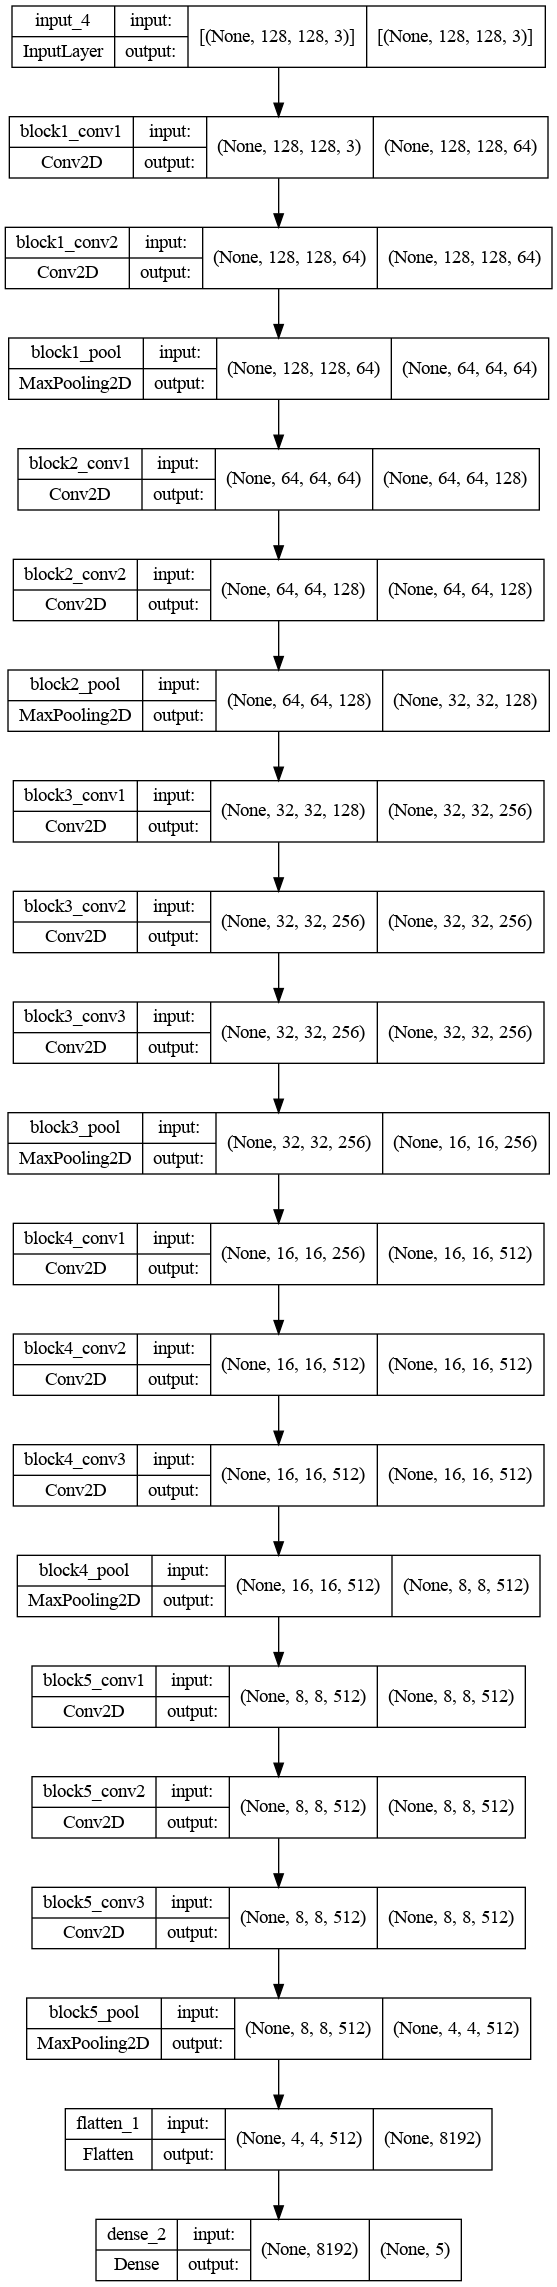

In [34]:
# On réunit le modèle avec la nouvelle sortie
TL_model=Model(inputs= base_model.input, outputs=prediction)
TL_model.summary()
plot_model(TL_model, to_file = "TL_model_plot.png", show_shapes = True, show_layer_names = True)

In [35]:
TL_model.compile(loss= 'categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

In [45]:
train_datagen=ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
test_datagen= ImageDataGenerator(rescale=1./255)

trainning_set= train_datagen.flow_from_directory(train_dir, target_size=(128, 128), batch_size= 32, class_mode='categorical')
test_set= test_datagen.flow_from_directory(test_dir, target_size=(128, 128), batch_size= 32, class_mode='categorical')

Found 32798 images belonging to 5 classes.
Found 8199 images belonging to 5 classes.


In [46]:
#Récupération des labels et des images de test 
# take(-1) take all batches

for images, labels in validate.take(-1):
    x_test = images.numpy()
    y_test = labels.numpy()
class_names= ['Photo', 'NoPhoto']
confusionMatrix_callback = ConfusionMatrixCallback(x_test, y_test, class_names)

In [47]:
TL_hostory=TL_model.fit(trainning_set, epochs=15, validation_data= test_set, callbacks=[tensorboard_callback,cp_callback,confusionMatrix_callback,early_stop_callback])

Epoch 1/15


2022-10-19 21:18:43.999979: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-10-19 21:18:44.000017: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


 466/1025 [============>.................] - ETA: 39s - loss: 0.3840 - accuracy: 0.8506

2022-10-19 21:19:18.172117: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.98GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-10-19 21:19:18.172149: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.98GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


1025/1025 [==============================] - ETA: 0s - loss: 0.3293 - accuracy: 0.8711
Epoch 1: val_loss improved from 0.29259 to 0.25054, saving model to logs/weight/20221019-205327


2022-10-19 21:20:09.757694: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.01GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-10-19 21:20:09.757740: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.01GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


1025/1025 [==============================] - 87s 84ms/step - loss: 0.3293 - accuracy: 0.8711 - val_loss: 0.2505 - val_accuracy: 0.9050
Epoch 2/15
1025/1025 [==============================] - ETA: 0s - loss: 0.2502 - accuracy: 0.9035
Epoch 2: val_loss did not improve from 0.25054
1025/1025 [==============================] - 85s 83ms/step - loss: 0.2502 - accuracy: 0.9035 - val_loss: 0.2507 - val_accuracy: 0.9075
Epoch 3/15
1025/1025 [==============================] - ETA: 0s - loss: 0.2310 - accuracy: 0.9109
Epoch 3: val_loss did not improve from 0.25054
1025/1025 [==============================] - 84s 82ms/step - loss: 0.2310 - accuracy: 0.9109 - val_loss: 0.2639 - val_accuracy: 0.9052
Epoch 4/15
1025/1025 [==============================] - ETA: 0s - loss: 0.2253 - accuracy: 0.9151
Epoch 4: val_loss improved from 0.25054 to 0.21796, saving model to logs/weight/20221019-205327
1025/1025 [==============================] - 84s 82ms/step - loss: 0.2253 - accuracy: 0.9151 - val_loss: 0.2180

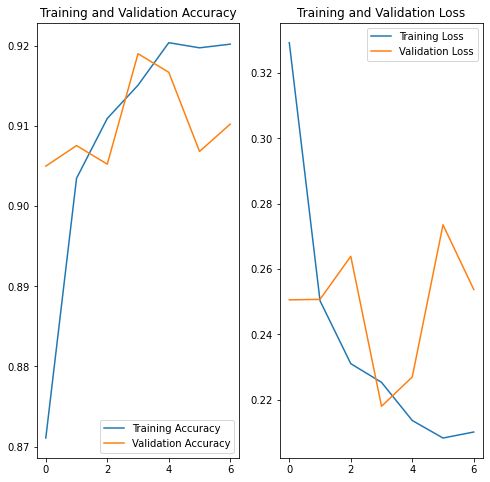

In [50]:
acc =TL_hostory.history['accuracy']
val_acc = TL_hostory.history['val_accuracy']

loss = TL_hostory.history['loss']
val_loss = TL_hostory.history['val_loss']

epochs_range = range(7)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [51]:
valid_loss, valid_accuracy = TL_model.evaluate_generator(test_set)
print(valid_accuracy)

/tmp/ipykernel_6737/3438821570.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  valid_loss, valid_accuracy = TL_model.evaluate_generator(test_set)


0.9102329611778259


In [52]:

y_pred=[]
y_real=[]
from tensorflow.keras.preprocessing import image

directory = os.fsencode('../Datasets/TouNum/dataset/multi-class/test/Painting')
counterBonneRep=0
counterFile=0
for file in os.listdir(directory):
     filename = os.fsdecode(file)
     if filename.endswith(".jpg") or filename.endswith(".png"): 
         counterFile=counterFile+1
         img = image.load_img('../Datasets/TouNum/dataset/multi-class/test/Painting/' + filename,target_size = (128,128))   #meme taille avec laquelle on a entrainée le modèle
         x = image.img_to_array(img)
         x = x[np.newaxis]
         predictions=TL_model.predict(x)
         score = tf.nn.softmax(predictions[0])
         y_pred.append(np.argmax(score))
         if (filename.__contains__("painting")):
          y_real.append(0)

directory = os.fsencode('../Datasets/TouNum/dataset/multi-class/test/Photo')
counterBonneRep=0
counterFile=0
for file in os.listdir(directory):
     filename = os.fsdecode(file)
     if filename.endswith(".jpg") or filename.endswith(".png"): 
         counterFile=counterFile+1
         img = image.load_img('../Datasets/TouNum/dataset/multi-class/test/Photo/' + filename,target_size = (128,128))   #meme taille avec laquelle on a entrainée le modèle
         x = image.img_to_array(img)
         x = x[np.newaxis]
         predictions=TL_model.predict(x)
         score = tf.nn.softmax(predictions[0])
         y_pred.append(np.argmax(score))
         if (filename.__contains__("photo")):
           y_real.append(1)

directory = os.fsencode('../Datasets/TouNum/dataset/multi-class/test/Schematics')
counterBonneRep=0
counterFile=0
for file in os.listdir(directory):
     filename = os.fsdecode(file)
     if filename.endswith(".jpg") or filename.endswith(".png"): 
         counterFile=counterFile+1
         img = image.load_img('../Datasets/TouNum/dataset/multi-class/test/Schematics/' + filename,target_size = (128,128))   #meme taille avec laquelle on a entrainée le modèle
         x = image.img_to_array(img)
         x = x[np.newaxis]
         predictions=TL_model.predict(x)
         score = tf.nn.softmax(predictions[0])
         y_pred.append(np.argmax(score))
         if (filename.__contains__("schematics")):
           y_real.append(2)

directory = os.fsencode('../Datasets/TouNum/dataset/multi-class/test/Sketch')
counterBonneRep=0
counterFile=0
for file in os.listdir(directory):
     filename = os.fsdecode(file)
     if filename.endswith(".jpg") or filename.endswith(".png"): 
         counterFile=counterFile+1
         img = image.load_img('../Datasets/TouNum/dataset/multi-class/test/Sketch/' + filename,target_size = (128,128))   #meme taille avec laquelle on a entrainée le modèle
         x = image.img_to_array(img)
         x = x[np.newaxis]
         predictions=TL_model.predict(x)
         score = tf.nn.softmax(predictions[0])
         y_pred.append(np.argmax(score))
         if (filename.__contains__("sketch")):
           y_real.append(3)

directory = os.fsencode('../Datasets/TouNum/dataset/multi-class/test/Text')
counterBonneRep=0
counterFile=0
for file in os.listdir(directory):
     filename = os.fsdecode(file)
     if filename.endswith(".jpg") or filename.endswith(".png"): 
         counterFile=counterFile+1
         img = image.load_img('../Datasets/TouNum/dataset/multi-class/test/Text/' + filename,target_size = (128,128))   #meme taille avec laquelle on a entrainée le modèle
         x = image.img_to_array(img)
         x = x[np.newaxis]
         predictions=TL_model.predict(x)
         score = tf.nn.softmax(predictions[0])
         y_pred.append(np.argmax(score))
         if (filename.__contains__("text")):
           y_real.append(4)

ValueError: The number of FixedLocator locations (5), usually from a call to set_ticks, does not match the number of ticklabels (2).

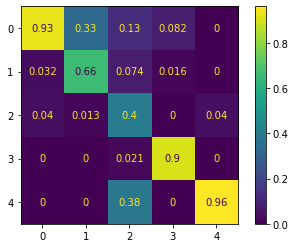

In [59]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm=confusion_matrix(y_real, y_pred,  normalize="pred")

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

disp.plot()

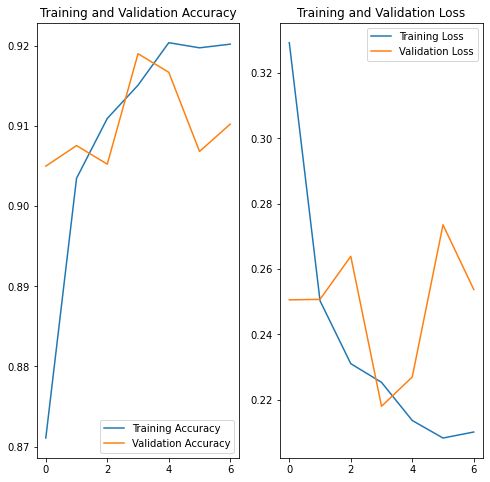

0.9102329611778259


In [57]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

print(valid_accuracy)

## __Modèle CNN pour une classification binaire__

In [33]:
from re import X
from csv import DictWriter
import csv
import matplotlib.pyplot as plt


def AccuracySave(n_dropout, nb_epoch, min_delta, patience, accuracy ):
  # Import DictWriter class from CSV module
  
  # list of column names 
  field_names = ['N_Dropout','Nb_Epoch', 'Min_Delta', 'Patience', 'Accuracy']
    
  # Dictionary
  dict={'N_Dropout':n_dropout,'Nb_Epoch': nb_epoch,'Min_Delta':min_delta,        #A mettre les bonnes caractéristiques
        'Patience':patience, 'Accuracy': accuracy}
    
  with open('Graphe.csv', 'a') as f_object:
        
      dictwriter_object = DictWriter(f_object, fieldnames=field_names)
    
      dictwriter_object.writerow(dict)
    
      f_object.close()

def ShowGraphe(xi, yi):
  x = []
  y = []
  with open('Graphe (5).csv', mode="r") as csv_file:
      reader = csv.reader(csv_file) 

      for item in reader:
          x.append(float(item[xi]))
          y.append(float(item[yi]))

  plt.plot(x, y)
      
  plt.xlabel('x - axis')
  plt.ylabel('y - axis')

  plt.title('Graph title')
  
  plt.show()

def ShowGraphe2(xi, yi):
  x = [1,5,2,3]
  y = [1,15,13,10]

  x = [1,2,3,5]
  y = ['0.85','0.88','0.868','0.863']

  plt.plot(x, y)
      
  plt.xlabel('x - axis')
  plt.ylabel('y - axis')

  plt.title('Graph title')
  
  plt.show()


In [35]:
path_datasets = "../Datasets/TouNum/dataset/binary"

In [36]:
def loadDataSet(path_datasets, size):
    return (
        tf.keras.preprocessing.image_dataset_from_directory(
          f"{path_datasets}/train/",
          validation_split=0.2,
          subset="training",
          seed=42,
          labels="inferred",
          image_size=size
        ),
        tf.keras.preprocessing.image_dataset_from_directory(
          f"{path_datasets}/train/",
          validation_split=0.2,
          subset="validation",
          seed=42,
          labels="inferred",
          image_size=size
        ),
        tf.keras.preprocessing.image_dataset_from_directory(
          f"{path_datasets}/test/",
          validation_split=0.99,
          subset="validation",
          seed=42,
          labels="inferred",
          image_size=size
        )
    )

In [39]:
train, validate, test = loadDataSet(path_datasets, (128, 128))

Found 32798 files belonging to 2 classes.
Using 26239 files for training.
Found 32798 files belonging to 2 classes.
Using 6559 files for validation.
Found 8199 files belonging to 2 classes.
Using 8117 files for validation.


In [40]:
class_names =  train.class_names
print(class_names)

['NoPhoto', 'Photo']


In [41]:

#Récupération des labels et des images de test 
# take(-1) take all batches
for images, labels in validate.take(-1):
    x_test = images.numpy()
    y_test = labels.numpy()

confusionMatrix_callback = ConfusionMatrixCallback(x_test, y_test, class_names)

Epoch 1/5
820/820 [==============================] - ETA: 0s - loss: 0.3505 - accuracy: 0.8279
Epoch 1: val_loss did not improve from 0.21600
820/820 [==============================] - 33s 40ms/step - loss: 0.3505 - accuracy: 0.8279 - val_loss: 0.2811 - val_accuracy: 0.8661
Epoch 2/5
820/820 [==============================] - ETA: 0s - loss: 0.2670 - accuracy: 0.8782
Epoch 2: val_loss did not improve from 0.21600
820/820 [==============================] - 30s 36ms/step - loss: 0.2670 - accuracy: 0.8782 - val_loss: 0.2648 - val_accuracy: 0.8818
Epoch 3/5
818/820 [============================>.] - ETA: 0s - loss: 0.2196 - accuracy: 0.9039
Epoch 3: val_loss did not improve from 0.21600
820/820 [==============================] - 30s 36ms/step - loss: 0.2194 - accuracy: 0.9040 - val_loss: 0.2331 - val_accuracy: 0.8969
Epoch 4/5
820/820 [==============================] - ETA: 0s - loss: 0.1851 - accuracy: 0.9212
Epoch 4: val_loss improved from 0.21600 to 0.21311, saving model to logs/weight/

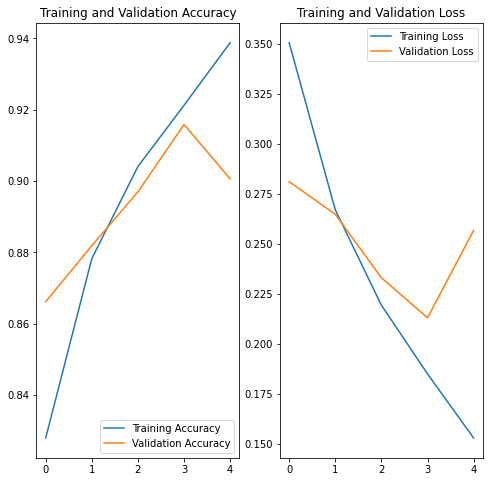

Récupération des données du modèle...
254/254 - 6s - loss: 0.2458 - accuracy: 0.9027 - 6s/epoch - 25ms/step

Test accuracy: 0.9026734232902527


In [42]:
# Mon model
# data_tr, data_val, data_test, n_dropout, nb_epoch, min_delta, patience, tensorboard_logs_dir, racine_dir, modele_name):

ts_logs_dir = '/content/LogsBoard'
# os.mkdir(racine)

racine = '/content/racine'
modele_name = 'test_modele'
output=0

data_tr= train
data_val= validate
data_test= test
n_dropout= 0.3
nb_epoch= 5
min_delta= 0
patience= 5
tensorboard_logs_dir= ts_logs_dir
racine_dir= racine
model_name= modele_name

# Création du modèle
model =tf.keras.models.Sequential([tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(n_dropout),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(5)])

# Compilation du modèle
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])


# Création des logs Tensorboard
logdir = tensorboard_logs_dir
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
# Création de l'early stoping
early_stopping_callback = tf.keras.callbacks.EarlyStopping("val_loss", min_delta=min_delta, patience=patience)

# Enrainement du modèle
history = model.fit(data_tr, validation_data=data_val, callbacks=[tensorboard_callback,cp_callback,confusionMatrix_callback, early_stopping_callback], epochs=nb_epoch)
# Récupération des valeurs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

#Affichage du graph
epochs_range = range(nb_epoch)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Récupération des poids et de la structure du modèle
print('Récupération des données du modèle...')
poids = model.get_weights()
path = racine_dir + "/" + modele_name
if os.path.exists(f"{path}") == False:
  os.mkdir(path)
  model.save(path)
  print('Récupération terminée !')

# Test du modèle
test_loss, test_acc = model.evaluate(data_test, verbose=2)
print('\nTest accuracy:', test_acc)

# Récupération dans le csv
AccuracySave(n_dropout,nb_epoch,  min_delta,  patience, test_acc )


## __Modèle Transfert Learning binary__

In [43]:
data_path='../Datasets/TouNum/dataset/binary'

train_dir= os.path.join(data_path, 'train')
test_dir= os.path.join(data_path, 'test')

In [44]:
IMG_SHAPE=(128,128,3)

base_model = VGG16(input_shape=IMG_SHAPE, include_top= False, weights='imagenet')
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [45]:
# On bloque l'apprentissage du modèle
base_model.trainable=False

In [46]:
# On définit nos couches de sorties
x= Flatten()(base_model.output)
prediction = Dense(2, activation= 'softmax')(x)

In [47]:
# On réunit le modèle avec la nouvelle sortie
TL_model=Model(inputs= base_model.input, outputs=prediction)
TL_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [48]:
TL_model.compile(loss= 'categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

In [49]:
train_datagen=ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen= ImageDataGenerator(rescale=1./255)

trainning_set= train_datagen.flow_from_directory(train_dir, target_size=(128, 128), batch_size= 32, class_mode='categorical')
test_set= test_datagen.flow_from_directory(test_dir, target_size=(128, 128), batch_size= 32, class_mode='categorical')

Found 32798 images belonging to 2 classes.
Found 8199 images belonging to 2 classes.


In [50]:
#Récupération des labels et des images de test 
# take(-1) take all batches

for images, labels in paths_test.take(-1):
    x_test = images.numpy()
    y_test = labels.numpy()
class_names= ['NoPhoto', 'Photo']
confusionMatrix_callback = ConfusionMatrixCallback(x_test, y_test, class_names)

In [51]:
TL_hostory=TL_model.fit(trainning_set, epochs=5, validation_data= test_set, callbacks=[tensorboard_callback,cp_callback,confusionMatrix_callback,early_stop_callback])

Epoch 1/5
1025/1025 [==============================] - ETA: 0s - loss: 0.2186 - accuracy: 0.9078
Epoch 1: val_loss improved from 0.21311 to 0.16928, saving model to logs/weight/20221007-071926
1025/1025 [==============================] - 163s 158ms/step - loss: 0.2186 - accuracy: 0.9078 - val_loss: 0.1693 - val_accuracy: 0.9329
Epoch 2/5
1025/1025 [==============================] - ETA: 0s - loss: 0.1855 - accuracy: 0.9248
Epoch 2: val_loss did not improve from 0.16928
1025/1025 [==============================] - 163s 159ms/step - loss: 0.1855 - accuracy: 0.9248 - val_loss: 0.2118 - val_accuracy: 0.9183
Epoch 3/5
1025/1025 [==============================] - ETA: 0s - loss: 0.1771 - accuracy: 0.9293
Epoch 3: val_loss did not improve from 0.16928
1025/1025 [==============================] - 162s 158ms/step - loss: 0.1771 - accuracy: 0.9293 - val_loss: 0.2390 - val_accuracy: 0.9089
Epoch 4/5
1025/1025 [==============================] - ETA: 0s - loss: 0.1677 - accuracy: 0.9328
Epoch 4: va

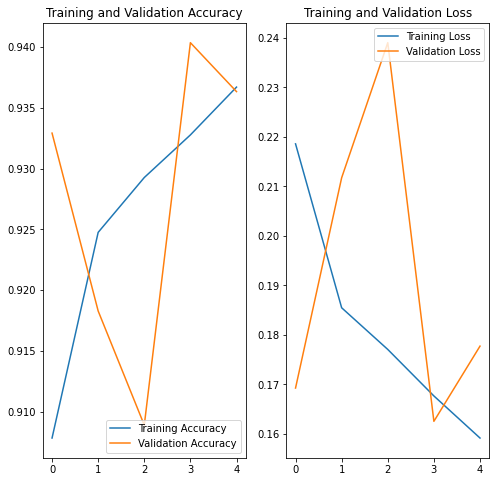

In [52]:
acc =TL_hostory.history['accuracy']
val_acc = TL_hostory.history['val_accuracy']

loss = TL_hostory.history['loss']
val_loss = TL_hostory.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [53]:
valid_loss, valid_accuracy = TL_model.evaluate_generator(test_set)
print(valid_accuracy)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


0.9363337159156799


## __Conclusion__

Après différents tests sur les quatre modèles précédents, nous pouvons remarquer que le transfert learning pour une classification multiclasse est un modèle qui correspond bien à nos attentes, avec le plus souvent une précision de plus de 90%.

Cela peut sembler logique, car le modèle du transfert learning possède un nombre de couches important et ce dernier est bien paramétré pour de la classification d'image.

## __Prédiction__

Il suffit de mettre quelques images dans un dossier en les renommant correctement, puis d'indiquer le path dans la variable directory.

Nous avons essayé avec quelques peintures que vous connaissez certainement, et nous pouvons constater les résultats.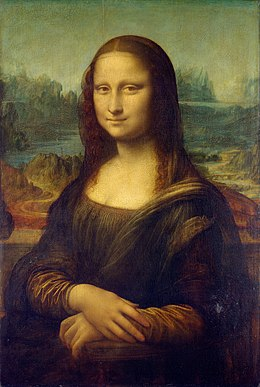

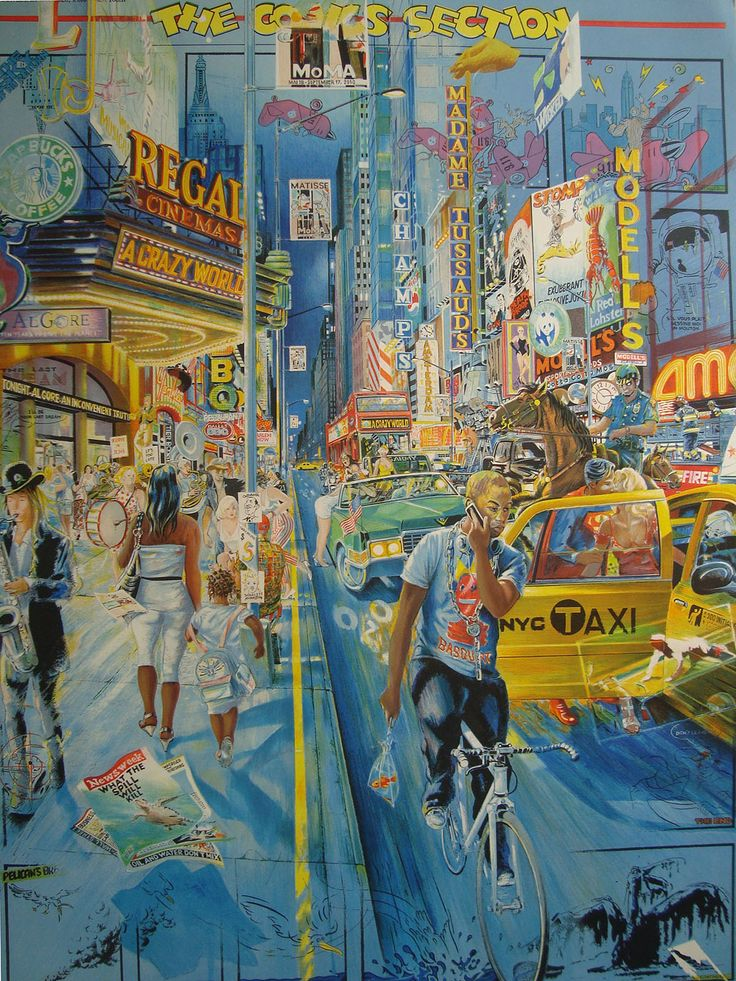

In [ ]:
from tensorflow.keras.preprocessing import image

directory = os.fsencode('/tmp/test')
counterBonneRep=0
counterFile=0
for file in os.listdir(directory):
     filename = os.fsdecode(file)
     if filename.endswith(".jpg") or filename.endswith(".png"): 
         counterFile=counterFile+1
         img = image.load_img('/tmp/test/' + filename,target_size = (128,128))   #meme taille avec laquelle on a entrainée le modèle
         img.show()
         x = image.img_to_array(img)
         x = x[np.newaxis]
         predictions=model.predict(x)
         score = tf.nn.softmax(predictions[0])
         if class_names[np.argmax(score)]== "Painting":
           if (filename.__contains__("painting")):
             counterBonneRep=counterBonneRep+1
         if class_names[np.argmax(score)]== "Photo":
           if (filename.__contains__("photo")):
             counterBonneRep=counterBonneRep+1
         if class_names[np.argmax(score)]== "Schematics":
           if (filename.__contains__("schematics")):
             counterBonneRep=counterBonneRep+1
         if class_names[np.argmax(score)]== "Sketch":
           if (filename.__contains__("sketch")):
             counterBonneRep=counterBonneRep+1
         if class_names[np.argmax(score)]== "Text":
           if (filename.__contains__("text")):
             counterBonneRep=counterBonneRep+1
         print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
              )

print("We tested {} file(s)".format(counterFile))
print("We have {:.2f} percent of good prediction ".format(100* (counterBonneRep/counterFile)))


This image most likely belongs to Painting with a 100.00 percent confidence.
This image most likely belongs to Painting with a 99.99 percent confidence.
We tested 2 file(s)
We have 100.00 percent of good prediction 
